In [25]:
import matplotlib.pyplot as plt
import os
import numpy as np

In [26]:
skin = open('skin.txt','r')
rl = skin.readlines()
w = []
count = [0,0]
for e in rl:
    if(e.find('\n') != -1):
        e = e[:-1]
    a = e.split('\t')
    #print(a)
    a = [int(i) for i in a]
    count[a[3]-1]+=1
    w.append(a)
    #print(e
skin.close()

In [27]:
total = count[0]+count[1]
prior_2 = count[1]/total
prior_1 = count[0]/total
print(prior_2,prior_1)

#prior_1 = 0.5
#prior_2 = 0.5

0.7924605295910747 0.20753947040892526


In [28]:
def get_feat(feat_idx):
    feat_tr_1,feat_test_1,feat_tr_2,feat_test_2= [],[],[],[]
    i1=0
    i2=0
    for e in w:
        if(e[3] == 1):
            if(i1<count[0]*0.9):
                feat_tr_1.append(e[feat_idx])
            else:
                feat_test_1.append(e[feat_idx])
            i1+=1
        else:
            if(i2<count[1]*0.9):
                feat_tr_2.append(e[feat_idx])
            else:
                feat_test_2.append(e[feat_idx])
            i2+=1
    Feat_tr_1 = np.array(feat_tr_1)
    Feat_test_1 = np.array(feat_test_1)
    Feat_test_1.shape = (Feat_test_1.size,1)
    Feat_tr_2 = np.array(feat_tr_2)
    Feat_test_2 = np.array(feat_test_2) 
    Feat_test_2.shape = (Feat_test_2.size,1)
    return Feat_tr_1,Feat_test_1,Feat_tr_2,Feat_test_2

#get the likelihood for each class
def get_likeli(feat1,feat2):
    #build frequency arrays for each
    freq1= np.bincount(feat1)
    freq2 = np.bincount(feat2)
    #build a maximum cap array for all values
    freq_1 = np.zeros(256)
    freq_2 = np.zeros(256)
    #fill frequency table into cap arrays
    freq_1[0:freq1.size] = freq1
    freq_2[0:freq2.size] = freq2
    #numerically calculate the likelihood array for each class using feature vector
    likeli1 = freq_1 / feat1.size
    likeli2 = freq_2 / feat2.size
    return likeli1,likeli2

#build posterior
def get_posterior(likeli1,likeli2, prior1=0.5,prior2=0.5):
    posterior1 = (likeli1*prior1) / (likeli1*prior1 + likeli2*prior2)
    posterior2 = (likeli2*prior2) / (likeli1*prior1 + likeli2*prior2)
    return posterior1,posterior2

def predict(post1,post2,x):
    if(post1[x] >= post2[x]):
        return 1
    else:
        return 0
    
def spredict(x,likeli1,likeli2,prior1=0.5,prior2=0.5):
    sz = x.size
    post1 = prior1
    post2 = prior2
    for z in x:
        for l in likeli1:
            post1*=l[z]
        for k in likeli2:
            post2*=k[z]
    return post1>=post2

#ccr for Skin Classification
def ccr1(test,likelis1,likelis2,prior1=0.5,prior2=0.5):
    cn = 0
    for n in test:
        cn+=spredict(n,likelis1, likelis2,prior1,prior2)
    return cn / test.size
#ccr for NoSkin Classification
def ccr2(test,likelis1,likelis2,prior1=0.5,prior2=0.5):
    cn = 0
    for n in test:
        cn+=1- spredict(n,likelis1, likelis2,prior1,prior2)
    return cn / test.size

def plot(graph1,graph2,xlabel,ylabel):
    plt.plot(range(graph1.size),graph1,label='Skin')
    plt.plot(range(graph2.size),graph2,label='No Skin')
    plt.legend(loc='upper center')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [29]:
B1_tr,B1_test,B2_tr,B2_test  = get_feat(0)
G1_tr,G1_test,G2_tr,G2_test  = get_feat(1)
R1_tr,R1_test,R2_tr,R2_test  = get_feat(2)

B1_lik, B2_lik = get_likeli(B1_tr,B2_tr)
G1_lik, G2_lik = get_likeli(G1_tr,G2_tr)
R1_lik, R2_lik = get_likeli(R1_tr,R2_tr)

B1_post, B2_post = get_posterior(B1_lik,B2_lik,prior_1,prior_2)
G1_post, G2_post = get_posterior(G1_lik,G2_lik,prior_1,prior_2)
R1_post, R2_post = get_posterior(R1_lik,R2_lik,prior_1,prior_2)

In [30]:
B1_ccr = ccr1(B1_test,[B1_lik],[B2_lik],prior_1,prior_2)
B2_ccr = ccr2(B2_test,[B1_lik],[B2_lik],prior_1,prior_2)
print('Feature B Skin CCR: ', B1_ccr)
print('Feature B No Skin CCR: ', B2_ccr)
B_mccr = min(B1_ccr,B2_ccr)
print('MCCR for Feature B: ', B_mccr,'\n')

G1_ccr = ccr1(G1_test,[G1_lik],[G2_lik],prior_1,prior_2)
G2_ccr = ccr2(G2_test,[G1_lik],[G2_lik],prior_1,prior_2)
print('Feature G Skin CCR: ', G1_ccr)
print('Feature G No Skin CCR: ', G2_ccr)
G_mccr = min(G1_ccr,G2_ccr)
print('MCCR for Feature G: ',G_mccr ,'\n')

R1_ccr = ccr1(R1_test,[R1_lik],[R2_lik],prior_1,prior_2)
R2_ccr = ccr2(R2_test,[R1_lik],[R2_lik],prior_1,prior_2)
print('Feature R Skin CCR: ', R1_ccr)
print('Feature R No Skin CCR: ', R2_ccr)
R_mccr =  min(R1_ccr,R2_ccr)
print('MCCR for Feature R: ',R_mccr,'\n')

best_mccr_single = max(B_mccr, G_mccr,R_mccr)
print(best_mccr_single)

Feature B Skin CCR:  0.932350049164
Feature B No Skin CCR:  0.513826664607
MCCR for Feature B:  0.513826664607 

Feature G Skin CCR:  0.685742379548
Feature G No Skin CCR:  0.67887120861
MCCR for Feature G:  0.67887120861 

Feature R Skin CCR:  1.0
Feature R No Skin CCR:  0.81837375766
MCCR for Feature R:  0.81837375766 

0.81837375766


In [31]:
#Multiple Features
# B and G
BG1_test =np.concatenate((B1_test, G1_test), axis=1)
BG2_test = np.concatenate((B2_test,G2_test), axis =1)
BG1_ccr = ccr1(BG1_test,[B1_lik,G1_lik],[B2_lik,G2_lik],prior_1,prior_2)
BG2_ccr = ccr2(BG2_test,[B1_lik,G1_lik],[B2_lik,G2_lik],prior_1,prior_2)
print('Features B & G Skin CCR: ', BG1_ccr)
print('Features B & G No Skin CCR: ', BG2_ccr)
BG_mccr = min(BG1_ccr,BG2_ccr)
print('MCCR for Feature B & G: ',BG_mccr ,'\n')


#B and R
BR1_test =np.concatenate((B1_test, R1_test), axis=1)
BR2_test = np.concatenate((B2_test,R2_test), axis =1)
BR1_ccr = ccr1(BR1_test,[B1_lik,R1_lik],[B2_lik,R2_lik],prior_1,prior_2)
BR2_ccr = ccr2(BR2_test,[B1_lik,R1_lik],[B2_lik,R2_lik],prior_1,prior_2)
print('Features B & R Skin CCR: ', BR1_ccr)
print('Features B & R No Skin CCR: ', BR2_ccr)
BR_mccr = min(BR1_ccr,BR2_ccr)
print('MCCR for Feature B & R: ',BR_mccr ,'\n')


#G and R
GR1_test =np.concatenate((G1_test, R1_test), axis=1)
GR2_test = np.concatenate((G2_test,R2_test), axis =1)
GR1_ccr = ccr1(GR1_test,[G1_lik,R1_lik],[G2_lik,R2_lik],prior_1,prior_2)
GR2_ccr = ccr2(GR2_test,[G1_lik,R1_lik],[G2_lik,R2_lik],prior_1,prior_2)
print('Features G & R Skin CCR: ', GR1_ccr)
print('Features G & R No Skin CCR: ', GR2_ccr)
GR_mccr = min(GR1_ccr,GR2_ccr)
print('MCCR for Feature G & R: ',GR_mccr ,'\n')

#B G R
BGR1_test = np.concatenate((B1_test, G1_test, R1_test), axis=1)
BGR2_test = np.concatenate((B2_test, G2_test,R2_test), axis =1)
BGR1_ccr = ccr1(BGR1_test,[B1_lik,G1_lik,R1_lik],[B2_lik,G2_lik,R2_lik],prior_1,prior_2)
BGR2_ccr = ccr2(BGR2_test,[B1_lik,G1_lik,R1_lik],[B2_lik,G2_lik,R2_lik],prior_1,prior_2)
print('Features B G R Skin CCR: ', BGR1_ccr)
print('Features B G R No Skin CCR: ', BGR2_ccr)
BGR_mccr = min(BGR1_ccr,BGR2_ccr)
print('MCCR for Feature G & R: ', BGR_mccr,'\n')

best_mccr_double = max(BG_mccr, BR_mccr, GR_mccr)
print(best_mccr_double)
best_mccr_triple = BGR_mccr

Features B & G Skin CCR:  0.42418879056
Features B & G No Skin CCR:  0.347340233792
MCCR for Feature B & G:  0.347340233792 

Features B & R Skin CCR:  0.10127826942
Features B & R No Skin CCR:  0.423914722694
MCCR for Feature B & R:  0.10127826942 

Features G & R Skin CCR:  0.338446411013
Features G & R No Skin CCR:  0.363844688192
MCCR for Feature G & R:  0.338446411013 

Features B G R Skin CCR:  0.140937397575
Features B G R No Skin CCR:  0.265358669344
MCCR for Feature G & R:  0.140937397575 

0.347340233792


In [32]:
#Multiple Features
#B and G
BG1_lik = B1_lik * G1_lik
BG2_lik = B2_lik * G2_lik
BG1_post,BG2_post = get_posterior(BG1_lik,BG2_lik,prior_1,prior_2)

#B and R
BR1_lik = B1_lik * R1_lik
BR2_lik = B2_lik * R2_lik
BR1_post,BR2_post = get_posterior(BR1_lik,BR2_lik,prior_1,prior_2)

#G and R
GR1_lik = G1_lik * R1_lik
GR2_lik = G2_lik * R2_lik
GR1_post,GR2_post = get_posterior(GR1_lik,GR2_lik,prior_1,prior_2)

#B G R
BGR1_lik = B1_lik * G1_lik * R1_lik
BGR2_lik = B2_lik * G2_lik * R2_lik
BGR1_post,BGR2_post = get_posterior(BGR1_lik,BGR2_lik,prior_1,prior_2)

Feature BG only


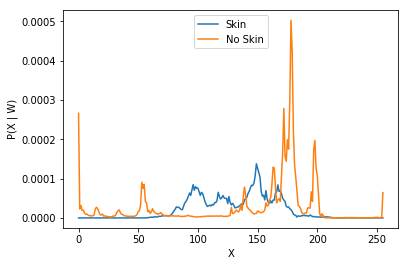

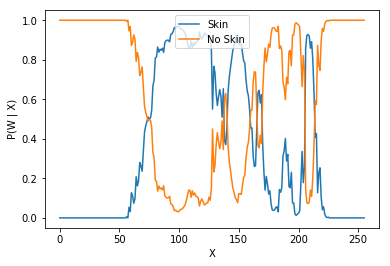



Feature BR only


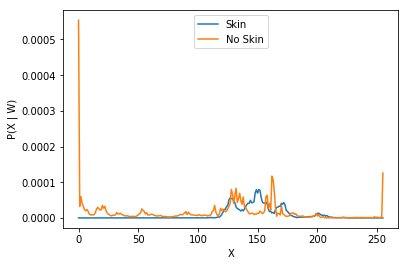

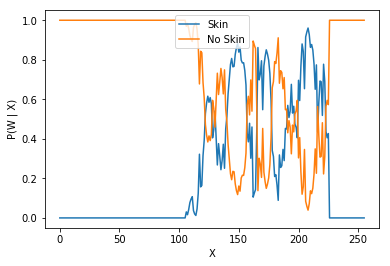



Feature GR only


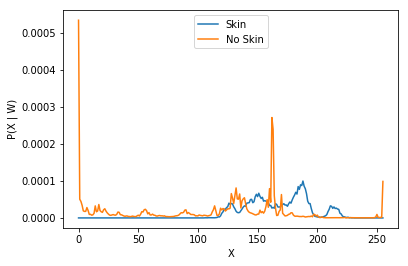

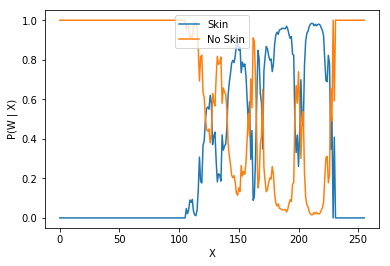

In [33]:
print('Feature BG only')
plot(BG1_lik,BG2_lik,'X','P(X | W)')
plot(BG1_post,BG2_post,'X','P(W | X)')

print('\n\nFeature BR only')
plot(BR1_lik,BR2_lik,'X','P(X | W)')
plot(BR1_post,BR2_post,'X','P(W | X)')

print('\n\nFeature GR only')
plot(GR1_lik,GR2_lik,'X','P(X | W)')
plot(GR1_post,GR2_post,'X','P(W | X)')

Feature B only


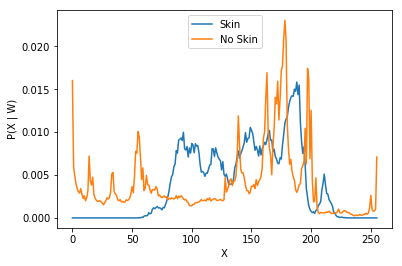

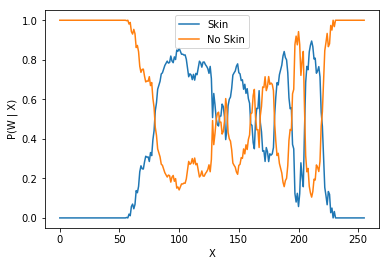



Feature G only


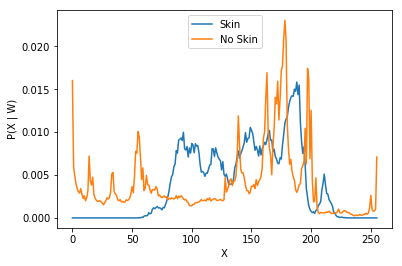

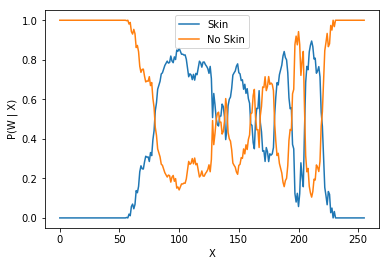



Feature R only


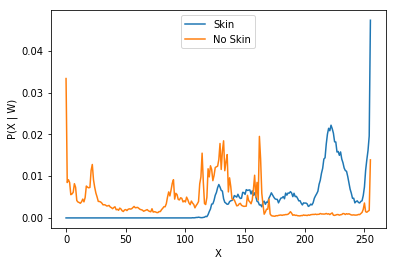

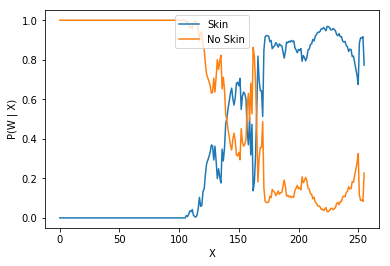

In [34]:
print('Feature B only')
plot(G1_lik,G2_lik,'X','P(X | W)')
plot(G1_post,G2_post,'X','P(W | X)')

print('\n\nFeature G only')
plot(G1_lik,G2_lik,'X','P(X | W)')
plot(G1_post,G2_post,'X','P(W | X)')

print('\n\nFeature R only')
plot(R1_lik,R2_lik,'X','P(X | W)')
plot(R1_post,R2_post,'X','P(W | X)')

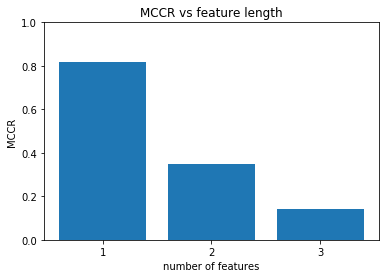

In [35]:
#Plot MCCR vs # of features
nf = range(1,4)
mccrs = [best_mccr_single, best_mccr_double, best_mccr_triple]
plt.title('MCCR vs feature length')
plt.xlabel('number of features')
plt.ylabel('MCCR')
plt.bar(nf,mccrs)
plt.ylim(0,1)
#plt.yticks(range(0,1))
plt.xticks((1,2,3))

plt.show()